# Model developement

## Data & Package import

In [ ]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import tensorflow as tf
from dotenv import load_dotenv
load_dotenv()
from utils.gcp import load_data_from_gcs
from google.auth import credentials
from google.cloud import storage


project_root = os.path.dirname(os.getcwd())
service_account = os.path.join(project_root, 'setup', os.getenv("GCP_SERVICE_ACCOUNT"))
client = storage.Client.from_service_account_json(service_account)



bucket_name = os.getenv("GCP_BUCKET_NAME")
file_name = "data/processed/20241118-011629__data_1.csv"
data = load_data_from_gcs(bucket_name, file_name, client)

data["tokens"] = data["tokens"].apply(lambda x: eval(x))
data["label"] = data["label"].astype(int)


# 1 - Data preprocessing

### EDA

#### Input Analysis

In [27]:
# Explore input length and uniqueness

# Length analysis in prepeparation for padding
data['tokens_length'] = data['tokens'].apply(lambda x: len(x))
mean_length = data['tokens_length'].mean()
quantiles_length = data['tokens_length'].quantile([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

# Unique tokens per sample
data["unique_tokens"] = data['tokens'].apply(lambda x: len(set(x)))
mean_unique_tokens = data['unique_tokens'].mean()
quantiles_unique_tokens = data['unique_tokens'].quantile([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])


# Vocabulary analysis
vocab_size = len(set([token for token in data['tokens'] for token in token]))


# Top most frequent tokens
token_count = {}
for row in data.tokens :
	for token in row :
		if token not in list(token_count.keys()):
			token_count[token] = 1
		else:
			token_count[token] += 1
token_count = dict(sorted(token_count.items(), key=lambda item: item[1], reverse=True))
top_tokens = dict(list(token_count.items())[:20])

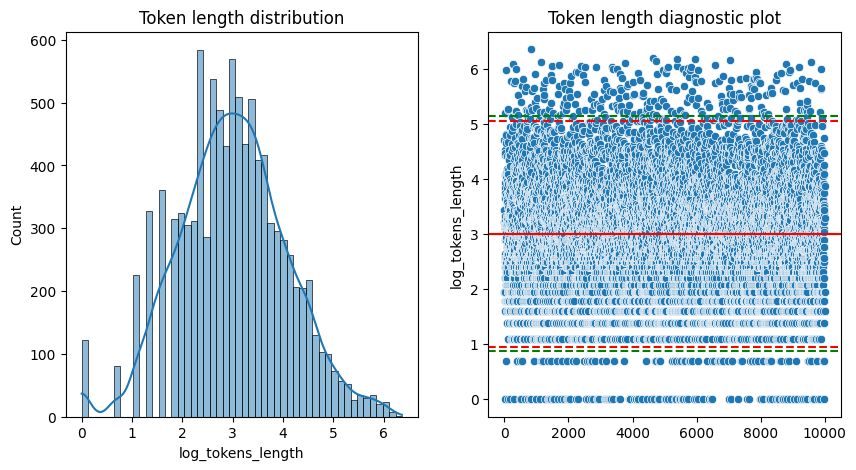

In [28]:
# Token length distribution and outlier detection
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Apply log transformation
data['log_tokens_length'] = data['tokens_length'].apply(lambda x: np.log(x+1))

# Token length distribution
sns.histplot(data['log_tokens_length'], kde=True, ax=ax[0])
ax[0].set_title("Token length distribution")

# Outlier detection
sns.scatterplot(x=list(data.index), y='log_tokens_length', data=data, ax=ax[1])
ax[1].set_title("Token length diagnostic plot")

# Outlier detection
mean = data['log_tokens_length'].mean()
median = data['log_tokens_length'].median()
std = data['log_tokens_length'].std()
mad = np.median(np.abs(data['log_tokens_length'] - median))

upper_bound = median + 2*(1.48*mad), mean + 2*std
lower_bound = median - 2*(1.48*mad), mean - 2*std

ax[1].axhline(upper_bound[0], color='r', linestyle='--')
ax[1].axhline(lower_bound[0], color='r', linestyle='--')
ax[1].axhline(upper_bound[1], color='g', linestyle='--')
ax[1].axhline(lower_bound[1], color='g', linestyle='--')
ax[1].axhline(mean, color='g', linestyle='-')
ax[1].axhline(median, color='r', linestyle='-')

plt.show();

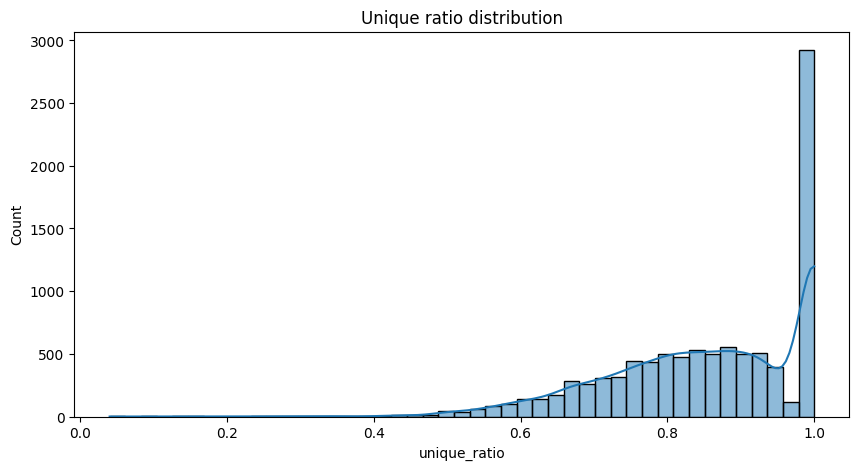

In [29]:
# Explore unique/length of tokens
data["unique_ratio"] = data['unique_tokens'] / data['tokens_length']

# Apply log transformation
epsilon = 1e-6
data['log_unique_ratio'] = data['unique_ratio']


# Unique ratio distribution
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.histplot(data['unique_ratio'], kde=True, ax=ax)
plt.title("Unique ratio distribution")
plt.show();

#### Remove outliers

In [43]:
# Remove outliers
data = data[(data['log_tokens_length'] < upper_bound[0]) & (data['log_tokens_length'] > lower_bound[0])]

# Remove empty tokens
data = data[data['tokens_length'] > 0]

# Remove tokens with low unique ratio
data = data[data['unique_ratio'] > 0.2]


#### Padding

# 2 - Baseline Model

#### Embedding

Token to index

In [83]:
# Vocabulary size and vocabulary list for embedding)
vocab = list(set([token for token in data['tokens'] for token in token]))
vocab.append("<PAD>")
vocab_size = len(vocab)
# Token to index
token_to_index = {token: idx for idx, token in enumerate(vocab)}

# Convert text tokens to index
token_to_index.get("not", token_to_index["<UNK>"])
data['tokens_index'] = data['tokens'].apply(lambda x: [token_to_index.get(token, token_to_index["<UNK>"]) for token in x])

Padding

In [79]:
# Use a subset of the data for padding test
subset = data.sample(100)

# Pad sequences
from tensorflow.keras.utils import pad_sequences

max_length = data.tokens_length.max()

test = pad_sequences(subset.tokens_index, maxlen=max_length, padding='post', truncating='post')
subset['padded_tokens'] = [list(row) for row in test]

subset.head(1)

,source,text,label,id,tokens,tokens_length,unique_tokens,log_tokens_length,unique_ratio,log_unique_ratio,tokens_index,padded_tokens
1348,toxic_comment,| old-user-2 = \n| old-date-2 =,0,98dd136c12204fab8b48c27250875e35,"[older, oleate]",2,2,1.098612,1.0,1.0,"[5772, 3871]","[5772, 3871, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
# Load the pre-trained model
from gensim.models import KeyedVectors
word2vec = KeyedVectors.load_word2vec_format(os.path.join(project_root, 'datasets/.originals/Google-News-Vectors-Negative-300.bin'), binary=True)

# Initialize the embedding matrix
embedding_dim = 300  # Word2Vec vectors are 300-dimensional
embedding_matrix = np.zeros((len(vocab), embedding_dim))

# Fill the embedding matrix with Word2Vec vectors
for i, word in enumerate(vocab):
    if word == "<PAD>":
        embedding_matrix[i] = np.zeros(embedding_dim)
    elif word == "<UNK>":
        embedding_matrix[i] = np.random.rand(embedding_dim)
    elif word in word2vec:
        embedding_matrix[i] = word2vec[word]
    else:
        embedding_matrix[i] = np.random.rand(embedding_dim)

(11367, (11367, 300))